In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine = load_wine()
print(wine.keys())
NUM_CLASSES = len(wine.target_names)
NUM_FEATURES = len(wine.feature_names)
RANDOM_SEED = 42

X = torch.tensor(wine.data, dtype=torch.float32)
y = torch.tensor(wine.target, dtype=torch.long)



dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])


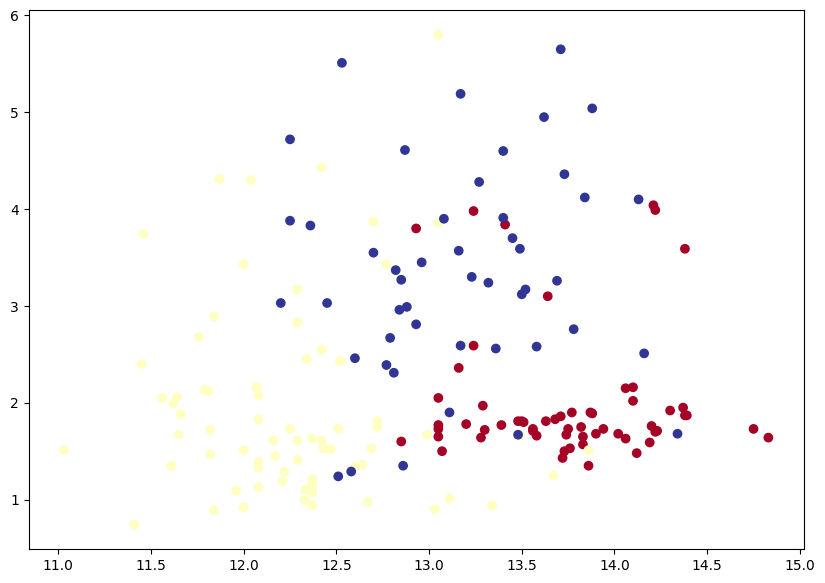

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [4]:


# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



'cpu'

In [5]:


from torch import nn
hidden_units = 32
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=hidden_units).to(device)
model_4



BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [6]:


import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



helper_functions.py already exists, skipping download


In [7]:
# Fit the model
#torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.001)


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc
# Set number of epochs
epochs = 100000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 12.26894, Acc: 31.69% | Test Loss: 15.79409, Test Acc: 38.89%
Epoch: 10 | Loss: 2.47297, Acc: 34.51% | Test Loss: 2.12669, Test Acc: 38.89%
Epoch: 20 | Loss: 0.92009, Acc: 58.45% | Test Loss: 0.80554, Test Acc: 66.67%
Epoch: 30 | Loss: 0.81640, Acc: 61.27% | Test Loss: 0.68961, Test Acc: 77.78%
Epoch: 40 | Loss: 0.84701, Acc: 61.97% | Test Loss: 0.68008, Test Acc: 75.00%
Epoch: 50 | Loss: 0.83338, Acc: 59.15% | Test Loss: 0.65742, Test Acc: 75.00%
Epoch: 60 | Loss: 0.80837, Acc: 61.97% | Test Loss: 0.64143, Test Acc: 75.00%
Epoch: 70 | Loss: 0.78055, Acc: 63.38% | Test Loss: 0.63405, Test Acc: 77.78%
Epoch: 80 | Loss: 0.77745, Acc: 63.38% | Test Loss: 0.62858, Test Acc: 77.78%
Epoch: 90 | Loss: 0.76864, Acc: 64.08% | Test Loss: 0.61825, Test Acc: 75.00%
Epoch: 100 | Loss: 0.73686, Acc: 63.38% | Test Loss: 0.59768, Test Acc: 77.78%
Epoch: 110 | Loss: 0.74933, Acc: 63.38% | Test Loss: 0.60622, Test Acc: 75.00%
Epoch: 120 | Loss: 0.77374, Acc: 63.38% | Test Loss: 0.61756,

Predictions: tensor([0, 0, 2, 0, 1, 0, 1, 2, 1, 2])
Labels: tensor([0, 0, 2, 0, 1, 0, 1, 2, 1, 2])
Test accuracy: 94.44444444444444%


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10201x2 and 13x32)

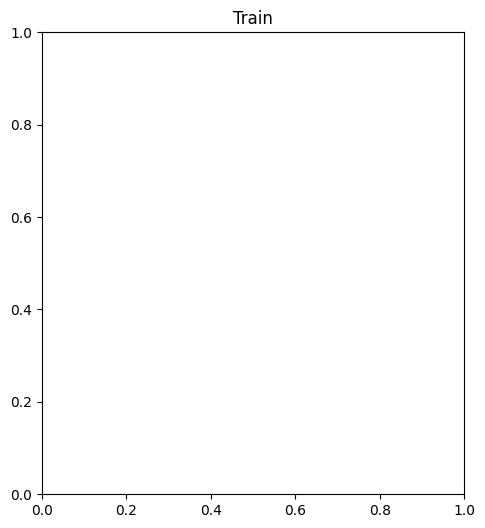

In [8]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)

# View the first 10 predictions
y_logits[:10]

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)
